# 2D CNN Aproach with scalogram

## Imports and setup

In [1]:
import os
import sys
import json
import csv 
import math
import re
from tempfile import NamedTemporaryFile
import shutil

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from tensorflow.keras.models import load_model
from keras.preprocessing import image

from ssqueezepy import cwt, icwt
from ssqueezepy.visuals import plot, imshow

from sklearn.metrics import confusion_matrix, accuracy_score

pd.set_option('display.max_rows', 100)
np.set_printoptions(formatter={'all':lambda x: str(x)})
pd.options.display.float_format = '{:.2f}'.format

plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)

In [2]:
#================================ Plotting ========================
def plot( df,  title, column_names, anomalies = False, difference=False):
    fig = plt.figure(figsize =(25, 8)) 
    #fig.suptitle(title) 
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
    max_xticks = 10
    xloc = plt.MaxNLocator(max_xticks)
    ax.xaxis.set_major_locator(xloc)
    counter = 0
    for column_name in column_names:
        ax.plot(df.index, df[column_name], label = column_name)
        if anomalies:
            if difference:
                ax.plot(df[df["Anomaly"]==1].index, df[column_name][df["Anomaly"]==1], marker = 'o', ms = 3, mec = 'r', mfc = 'r', linestyle = "None", label="False anomalies")
                ax.plot(df[df["Anomaly"]==-1].index, df[column_name][df["Anomaly"]==-1], marker = 'o', ms = 3, mec = 'g', mfc = 'g', linestyle = "None", label="False norms")
            else:
                if counter == len(column_names)-1:
                    ax.plot(df[df["Anomaly"]==1].index, df[column_name][df["Anomaly"]==1], marker = 'o', ms = 3, mec = 'r', mfc = 'r', linestyle = "None", label="Anomalies")
                else:
                    ax.plot(df[df["Anomaly"]==1].index, df[column_name][df["Anomaly"]==1], marker = 'o', ms = 3, mec = 'r', mfc = 'r', linestyle = "None")
                counter+=1
    fig.autofmt_xdate(rotation=15)
    ax.legend(fontsize=20)
    return fig

#================================ Data and directory management ========================

def create_dir(path):
    directory = os.path.dirname(path)
    if not os.path.exists(directory):
        os.makedirs(directory)
        
def extract_name_data(name):
    regex = r"(?P<columns>.+)-(?P<row_length>\d+)L(?P<step_size>\d+)S(?P<test_size>\d+)T"
    groups = re.match(regex, name)
    
    columns = groups.group('columns').split('&')
    row_length = int(groups.group('row_length'))
    step_size =  int(groups.group('step_size'))
    test_size = int(groups.group('test_size'))
    
    return columns, row_length, step_size, test_size

def save_fig(fig, file_path):
    fig.savefig(file_path, facecolor='white', transparent=False, dpi = 300, bbox_inches='tight')
    plt.close(fig)   

def save_data_csv(test_name,  cm_image, accuracy, accuracy_t, columns, row_length, step_size, test_size, comment):
    dir_path = f'../images/CNN/2DCNN/'
    filename = "test_results.csv"
    file_path = dir_path + filename

    true_negative =  cm_image[0][0]
    false_negative = cm_image[1][0]
    true_positive = cm_image[1][1]
    false_positive =  cm_image[0][1]
    
    
    row = [ test_name, columns, row_length, step_size, test_size, 
           true_negative, false_negative, true_positive, false_positive, accuracy, accuracy_t, comment]

    if os.path.exists(file_path):
        with open(file_path , 'a+', newline='') as csvFile:
            writer = csv.writer(csvFile, delimiter=',', quotechar='"')
            writer.writerow(row)     
    else:
        fields = [ "test_name", "columns", "row_length", "step_size", "test_size", 
                   "true_negative", "false_negative", "true_positive", "false_positive", "accuracy", "accuracy_t", "comment"]

        with open(file_path, 'w') as csvfile: 
            writer = csv.writer(csvfile) 
            writer.writerow(fields) 
            writer.writerow(row)
            

#================================ Data processing ========================
def choose_models():
    models = os.listdir(f'models/')
    models.sort()
    models.pop(0)
    print("Existing models:")
    counter = 1
    for model in models:
        print(f'{counter}) {model}')
        counter += 1
    print("\n")
    chosen_models = input("Choose model number: ").split(',')
    models_out = []
    for model in chosen_models:
        models_out.append(models[int(model)-1])
    print(models_out)
    return models_out

def comp(o):
    return int(o.split('_')[1].split('.')[0])

def find_datasets(models):
    datasets = []
    for model in models:
        datasets.append(model)
    return datasets


def get_batch_anomalies(Y_predicted, counter,rows_len, step,first_element, last_element):
    anomalies = np.zeros(rows_len)
    batches_considered = int(math.ceil(rows_len/step))
    if Y_predicted[counter] == 1:
        if (Y_predicted[counter-batches_considered+1:counter+1].squeeze() == np.ones(batches_considered)).all():
            anomalies[:] = 1
    anomalies = anomalies[:last_element-first_element]
    return anomalies


def reverse_sets(X, Y_predicted, step, len_test):
    
    rows_num = len(X)
    rows_len = len(X[0])
    
    values = np.zeros((rows_num*step+rows_len-step, len(X[0][0])))
    anomalies = np.zeros(rows_num*step+rows_len-step)
      
    counter = 0
    for row in X:
        if counter == rows_num:
            shift = step
        else:
            shift = rows_len
        first_element = counter*step
        last_element = counter*step + shift
        values[first_element:last_element, :] = row[:shift, :]
        anomalies[first_element:last_element] = get_batch_anomalies(Y_predicted, counter,rows_len, step, first_element, last_element)
        counter +=1
        
    values = values[-len_test:]
    anomalies = anomalies[-len_test:]
    return values, anomalies


## Choosing and loading model + dataset , predicting

Existing models:
1) B1_sigmoid&B2_sigmoid&MB_sigmoid&BMB_sigmoid-40L20S60T
2) B1_sigmoid&B2_temp&MB_temp&BMB_temp-40L20S60T
3) B1_sigmoid-20L10S60T
4) B1_sigmoid-40L10S60T
5) B1_sigmoid-40L20S60T
6) B1_sigmoid-40L40S60T
7) B1_sigmoid-80L40S60T
8) B1_sigmoid-80L80S60T
9) B1_temp&B2_temp&MB_temp&BMB_temp-40L20S60T
10) B1_temp-40L20S60T


Choose model number: 1,2,3,4,5,6,7,8,9,10
['B1_sigmoid&B2_sigmoid&MB_sigmoid&BMB_sigmoid-40L20S60T', 'B1_sigmoid&B2_temp&MB_temp&BMB_temp-40L20S60T', 'B1_sigmoid-20L10S60T', 'B1_sigmoid-40L10S60T', 'B1_sigmoid-40L20S60T', 'B1_sigmoid-40L40S60T', 'B1_sigmoid-80L40S60T', 'B1_sigmoid-80L80S60T', 'B1_temp&B2_temp&MB_temp&BMB_temp-40L20S60T', 'B1_temp-40L20S60T']


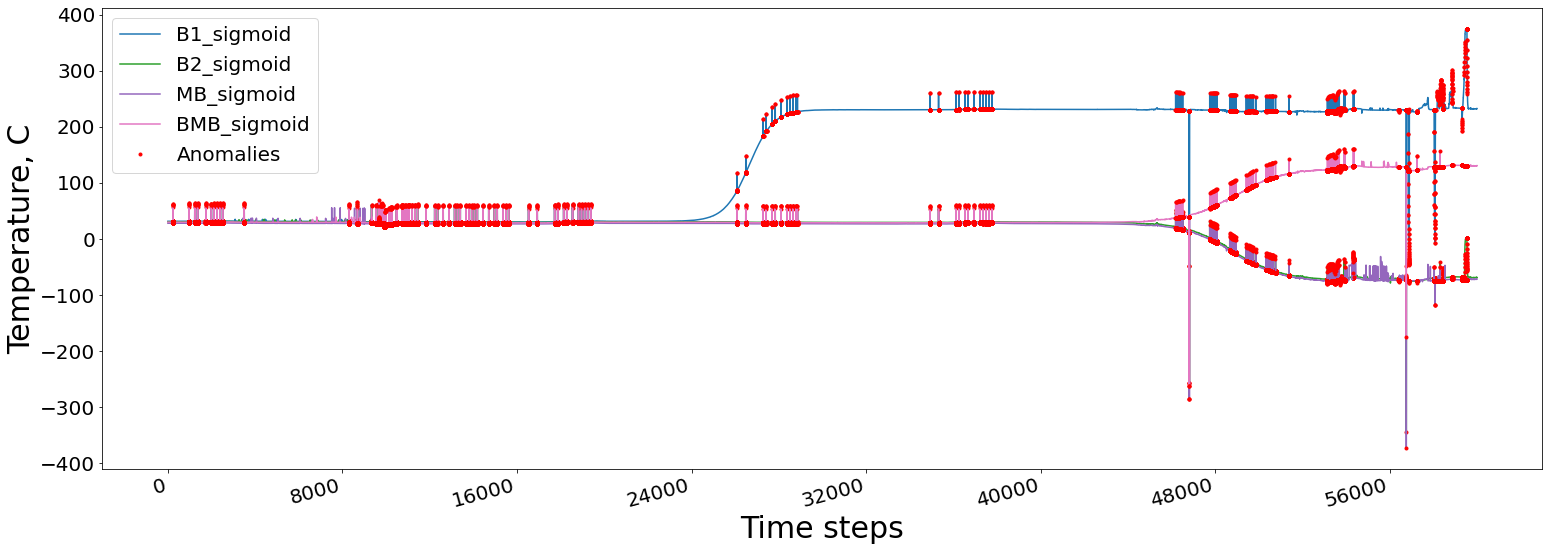

B1_sigmoid-B2_sigmoid-MB_sigmoid-BMB_sigmoid-40L20S60T done!


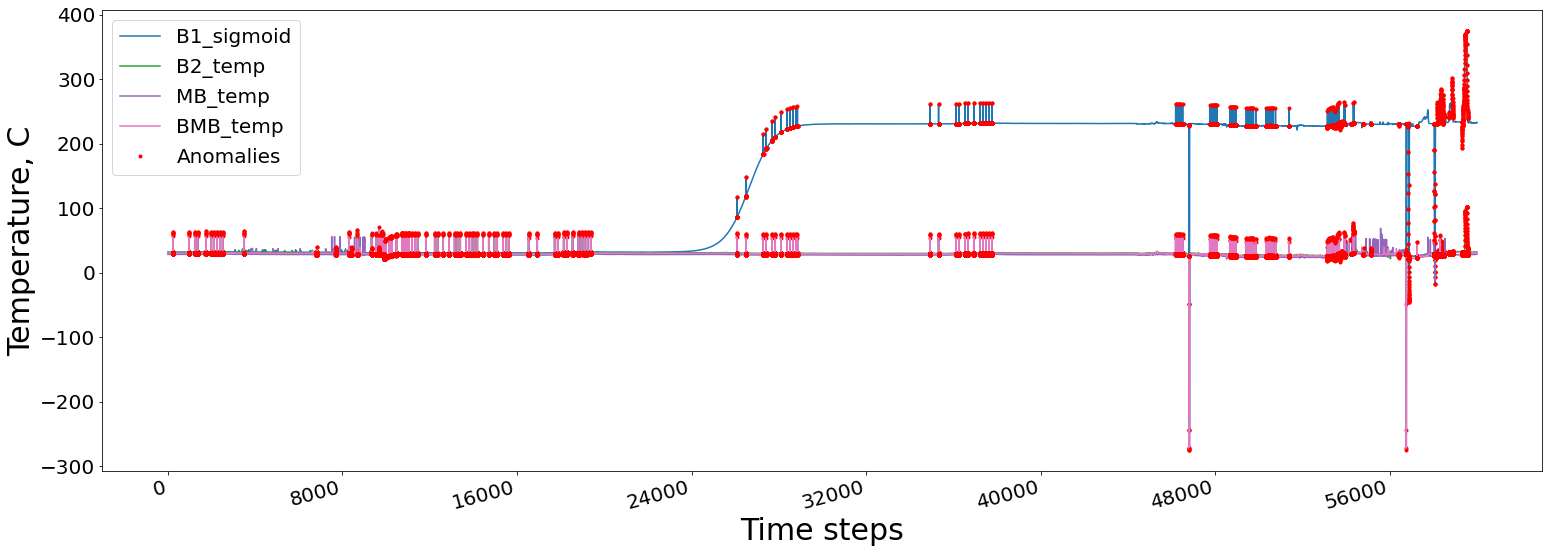

B1_sigmoid-B2_temp-MB_temp-BMB_temp-40L20S60T done!


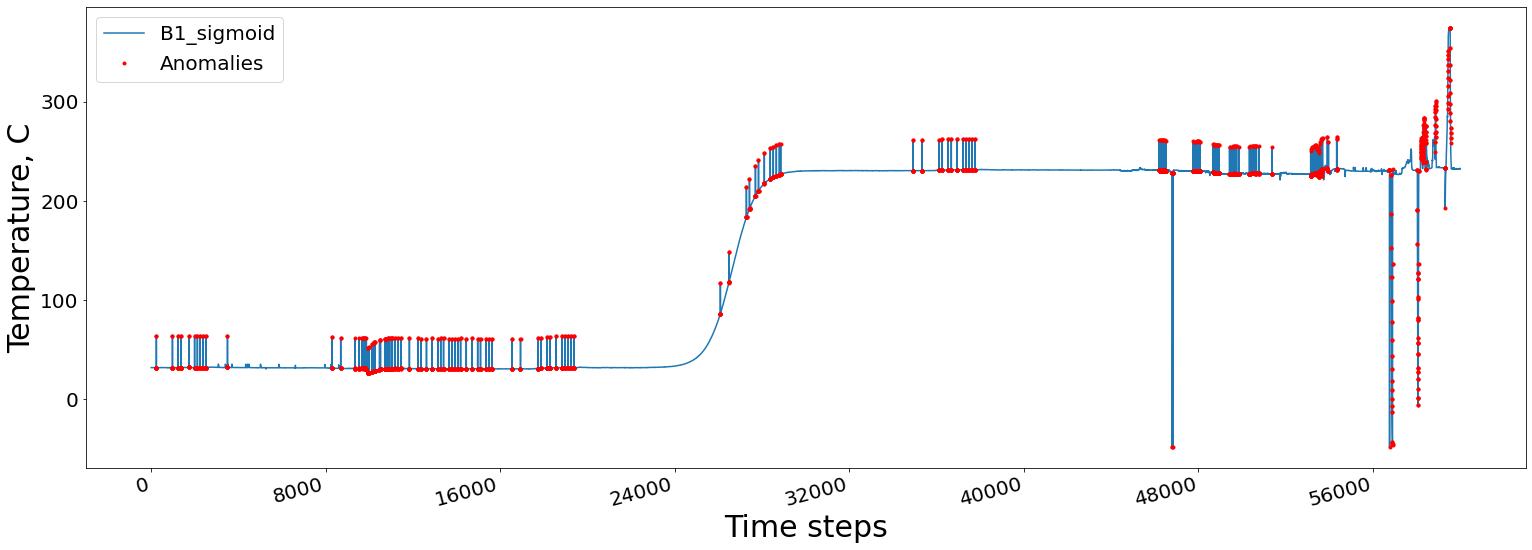

B1_sigmoid-20L10S60T done!


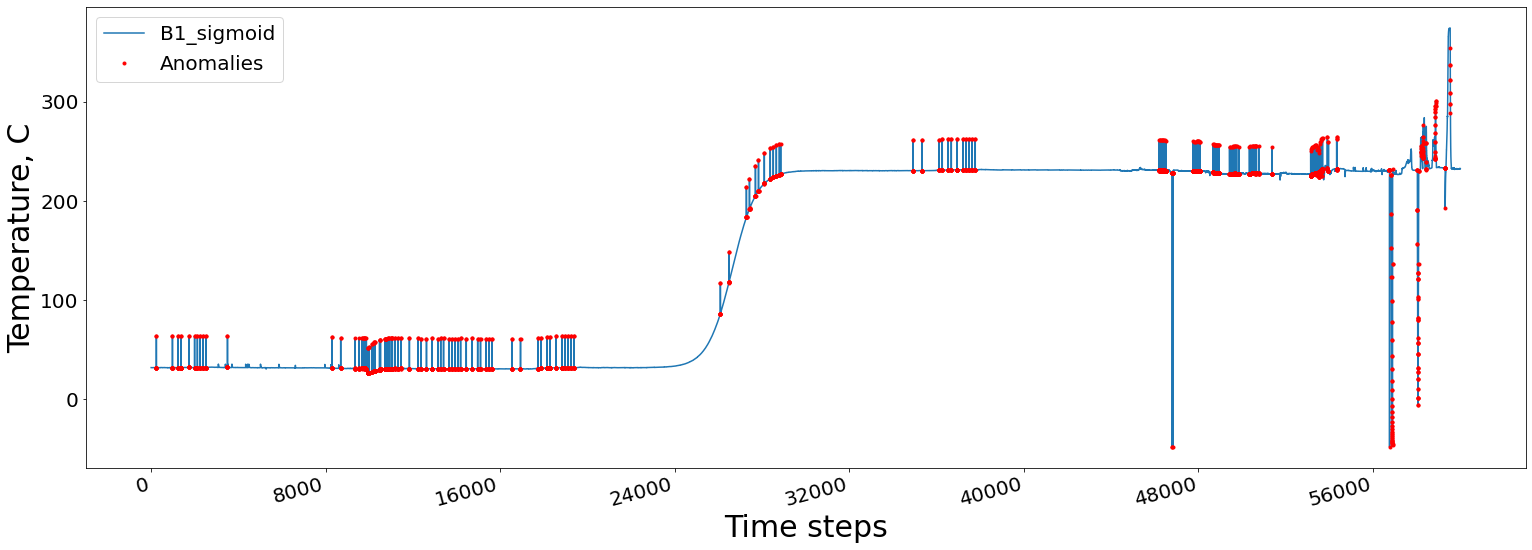

B1_sigmoid-40L10S60T done!


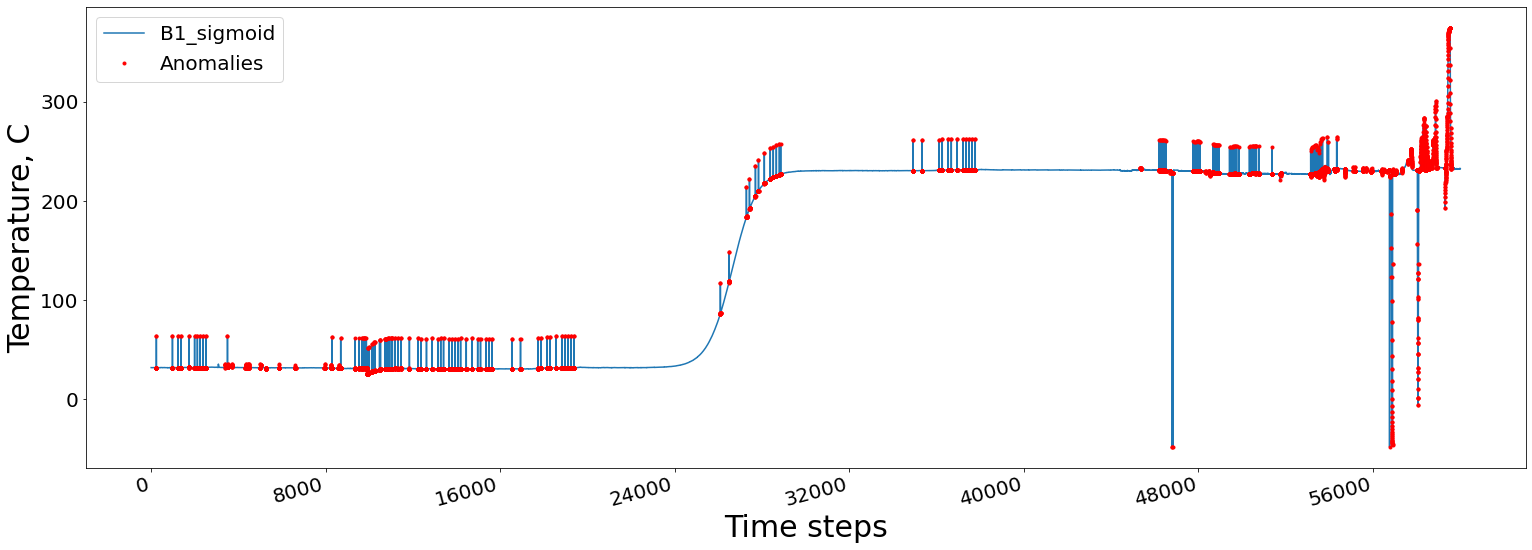

B1_sigmoid-40L20S60T done!


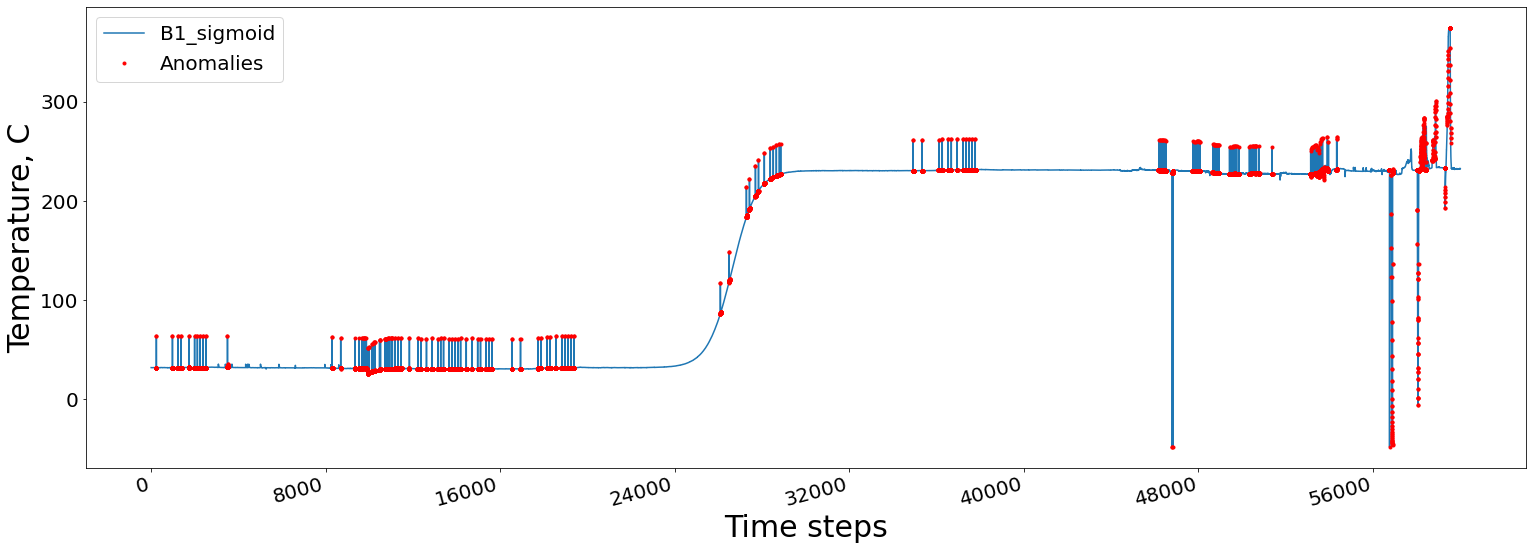

B1_sigmoid-40L40S60T done!


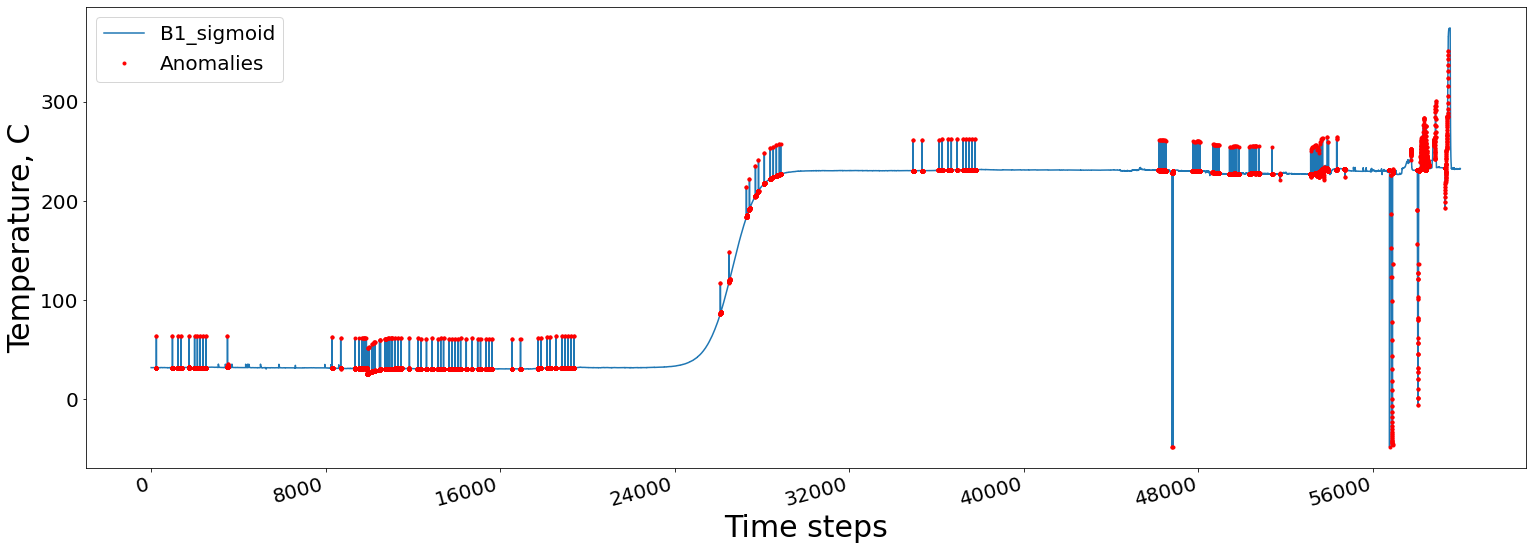

B1_sigmoid-80L40S60T done!


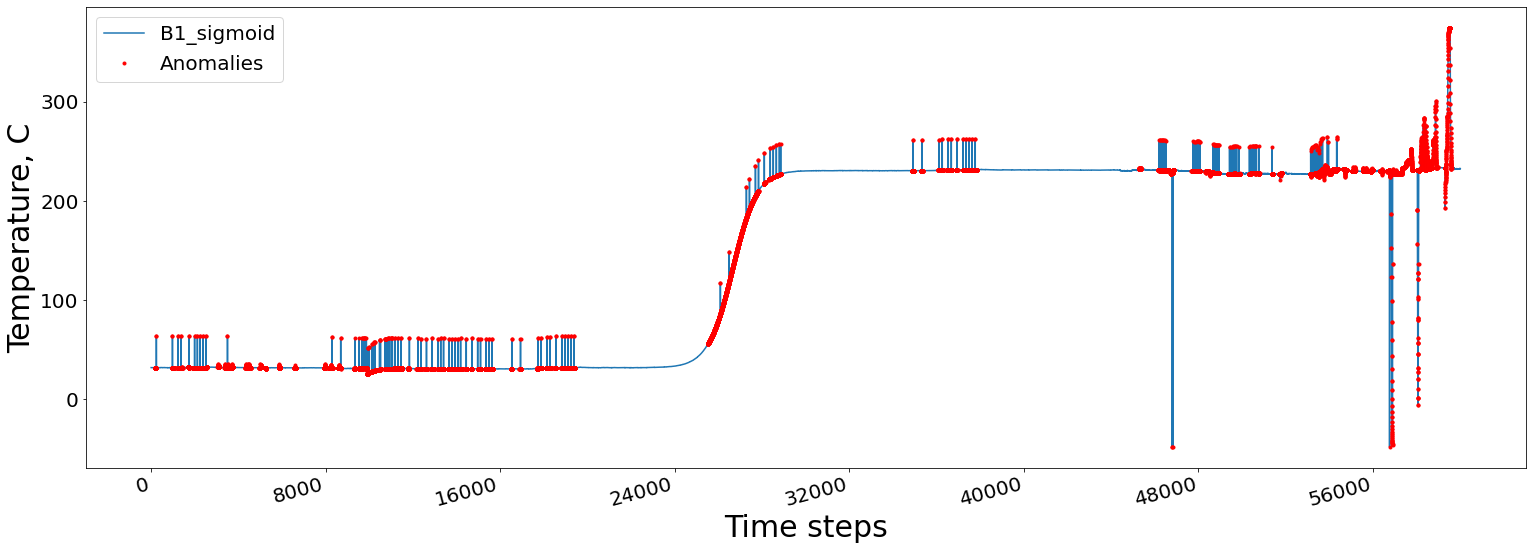

B1_sigmoid-80L80S60T done!


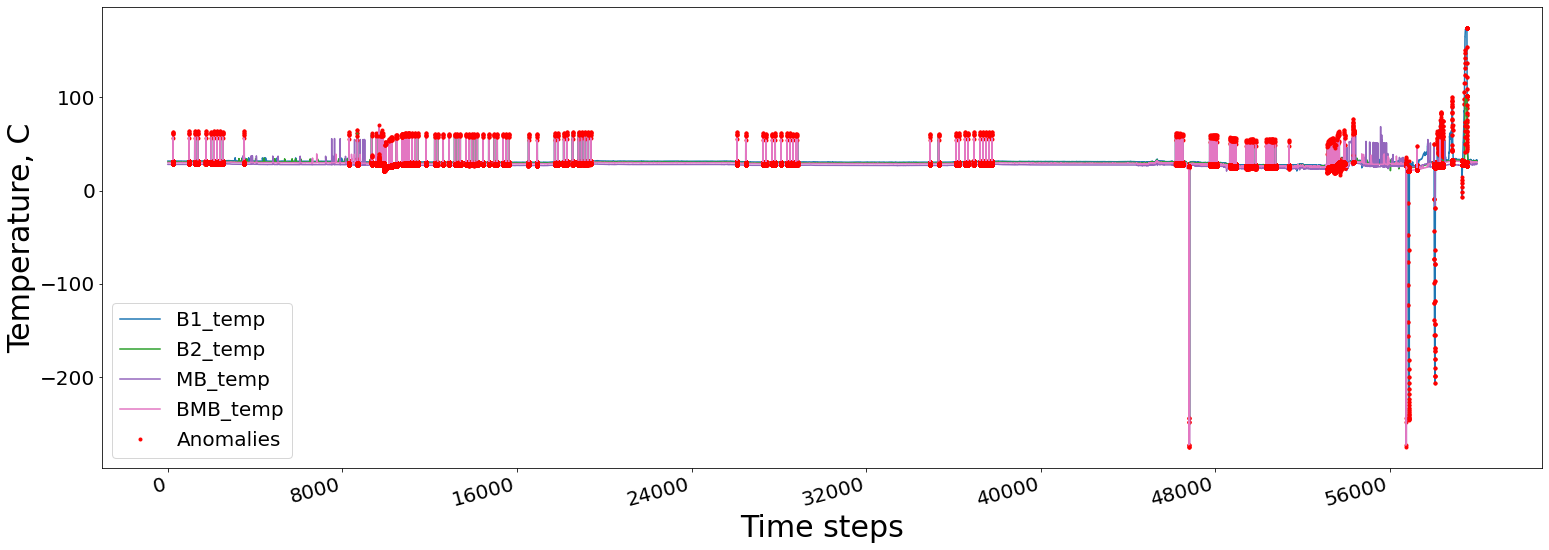

B1_temp-B2_temp-MB_temp-BMB_temp-40L20S60T done!


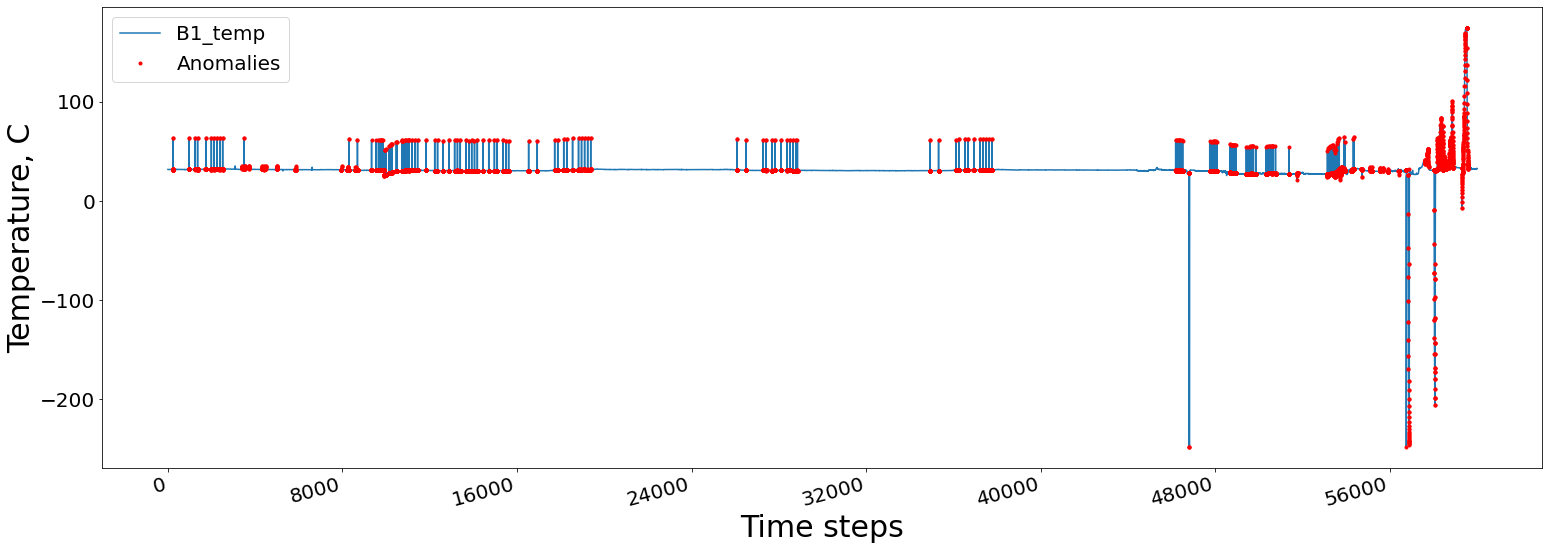

B1_temp-40L20S60T done!


In [3]:
models = choose_models()
datasets = find_datasets(models) 

#models = ['B1_temp-40L20S60T']
#datasets = ['BCR_1_Power-40L20S60T']

regex = r"(?P<columns>.+)-(?P<row_length>\d+)L(?P<step_size>\d+)S(?P<test_size>\d+)T"

for i in range(0, len(models)):
    model_name = models[i]
    dataset_name = datasets[i]

    columns, row_length, step_size, test_size = extract_name_data(dataset_name)
    
    path=f'Models/{model_name}'
    model=load_model(path)
    
    # Predicting
    X = np.load(f'datasets/{dataset_name}/X.npy')
    original_data = np.load(f'datasets/{dataset_name}/original_data.npy', allow_pickle=True)
    X_test = np.load(f'datasets/{dataset_name}/x_test.npy')
    Y_test = np.load(f'datasets/{dataset_name}/y_test.npy')
    Y_predicted = np.round(model.predict(X_test))
    
    """i = 27000
    starting = int(i/step_size)
    Wx = X_test[starting, :, :, 0] + 1j* X_test[starting, :, :, 1]
    fig = plt.figure( figsize=(6,4))
    imshow(Wx, abs=1, show=1, borders=0, fig=fig, xlabel="Time step", ylabel="Scale number")
    starting_or = 40000 + i
    print(starting_or)
    plt.plot(original_data[starting_or:starting_or+row_length])"""
    
    len_test = int(len(original_data)*test_size/100)
    
    # Reconstructing original info
    values, anomalies = reverse_sets(X[-len(X_test):], Y_predicted, step_size, len_test)
    
    # Creating dfs
    df_predicted = pd.DataFrame(values, columns = columns)
    df_predicted["Anomaly"] = anomalies
    
    df_original = pd.DataFrame(original_data, columns = columns+["Anomaly"])
    df_original["Anomaly"] = df_original["Anomaly"].astype(int)
    split_value = int(len(df_original)*(1-test_size/100))
    df_training = df_original.iloc[:split_value,:]
    df_original_predict = df_original.iloc[split_value:,:]
    
    original_anomalies = df_original_predict['Anomaly'].values
    original_values = df_original_predict[columns].values

    df_test = pd.DataFrame(original_values, columns=columns)
    df_test["Anomaly_orig"] =  original_anomalies
    df_test["Anomaly_pred"] =  anomalies
    df_test["Anomaly"] =  df_test["Anomaly_pred"] - df_test["Anomaly_orig"]
    
    
    # Plotting results
    
    fig1 = plot( df_predicted,  dataset_name+"_prediction", columns, anomalies = True)
    plt.xlabel('Time steps', fontsize=30)
    plt.ylabel('Temperature, C', fontsize=30)
    plt.show()
    #fig2 = plot( df_original_predict,  dataset_name+"_original_predict", columns, anomalies = True)
    #fig3 = plot( df_test,  dataset_name+"_difference", columns, anomalies = True, difference=True)
    #fig4 = plot( df_training,  dataset_name+"_training", columns, anomalies = True)
    #plt.show()
    
    cm = confusion_matrix(Y_test,Y_predicted)
    accuracy = accuracy_score(Y_test,Y_predicted)
    accuracy_t = accuracy_score(original_anomalies, anomalies)
    
    # Saving results
    save = True
    if save:
        comment = ""
        test_name = dataset_name.replace("&", "-")
        save_fig(fig1, f"../images/CNN/2DCNN/{test_name}.svg")
        save_fig(fig1, f"/Users/mykytaprokayev/Documents/TUM/Master Thesis/latex/images/{test_name}.svg")
        #save_fig(fig2, dir_path+"original")
        #save_fig(fig3, dir_path+"difference")
        #save_fig(fig4, dir_path+"training_data")
        save_data_csv(test_name, cm, accuracy, accuracy_t, columns, row_length, step_size, test_size, comment)
        command = f"/Applications/Inkscape.app/Contents/MacOS/inkscape -D /Users/mykytaprokayev/Documents/TUM/Master\ Thesis/latex/images/{test_name}.svg  -o /Users/mykytaprokayev/Documents/TUM/Master\ Thesis/latex/images/{test_name}.pdf --export-latex"
        os.system(command)
    
    print(f'{test_name} done!')